# Question 2: What is the average height of the players?

---

## Overview

To answer this question, I aim to process a large dataset of tennis match data to extract the heights of players and calculate the average height of them.

This is done using efficient data handling and parallel processing techniques. The dataset is stored in Parquet files, and I use ThreadPoolExecutor for parallelization, as well as TQDM for visual progress tracking.

I ensured that each player was only counted once by removing duplicates based on `player_id`. 
This guarantees that players who appeared in multiple matches do not skew the average.

**The processing pipeline included:**

- Automatically detecting date folders inside the dataset.
- Reading thousands of parquet files efficiently using `pandas.read_parquet()` with `ThreadPoolExecutor`.
- Skipping unreadable or corrupted files and reporting their count.
- Dropping records with missing height or player ID.
- Calculating the average height from the unique set of valid players.


In [1]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def load_file(file_path):
    try:
        # Read only the necessary columns (player_id and height)
        df = pd.read_parquet(file_path, columns=['player_id', 'height'])
        return df
    except Exception:
        return None
    
def load_unique_player_heights(base_path):
    # Automatically detect folders that look like dates (e.g.20240201)
    date_folders = [f for f in os.listdir(base_path) if f.isdigit()]
    match_files = []

    for folder in date_folders:
        path_pattern = os.path.join(base_path, folder, 'data', 'raw', 'raw_match_parquet', '*.parquet')
        match_files.extend(glob.glob(path_pattern))

    skipped_files = 0
    dfs = []

    print(f"📂 Total parquet files found: {len(match_files)}")

    # Using ThreadPoolExecutor to process the files in parallel
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(load_file, file): file for file in match_files}

        for future in tqdm(as_completed(futures), total=len(futures), desc="Reading parquet files"):
            df = future.result()
            if df is not None:
                dfs.append(df)
            else:
                skipped_files += 1

    if not dfs:
        return None, skipped_files, 0, 0

    all_data = pd.concat(dfs, ignore_index=True)
    all_data.dropna(subset=['player_id', 'height'], inplace=True)

    total_valid_rows = len(all_data)
    unique_players = all_data.drop_duplicates(subset='player_id')
    num_unique_players = len(unique_players)

    return unique_players, skipped_files, len(match_files), total_valid_rows

In [3]:
# Base path to data
base_path = "../data/tennis_data"

print("🚀 Loading unique player heights...")
unique_heights_df, skipped, total_files, valid_rows = load_unique_player_heights(base_path)

print("\n📊 Processing Summary:")
print(f"• Total files scanned: {total_files}")
print(f"• Files skipped due to error: {skipped}")
print(f"• Total valid rows with player_id & height: {valid_rows}")

if unique_heights_df is not None and not unique_heights_df.empty:
    print(f"• Unique players found: {len(unique_heights_df)}")
    avg_height = unique_heights_df['height'].mean()
    print(f"• ✅ Average height of unique players: {avg_height:.2f} m")
else:
    print("❌ No valid player height data found.")

🚀 Loading unique player heights...
📂 Total parquet files found: 316802


Reading parquet files: 100%|██████████| 316802/316802 [02:43<00:00, 1938.22it/s]
C:\Users\fatii\AppData\Local\Temp\ipykernel_7768\865462212.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat(dfs, ignore_index=True)



📊 Processing Summary:
• Total files scanned: 316802
• Files skipped due to error: 266989
• Total valid rows with player_id & height: 27861
• Unique players found: 1349
• ✅ Average height of unique players: 1.82 m


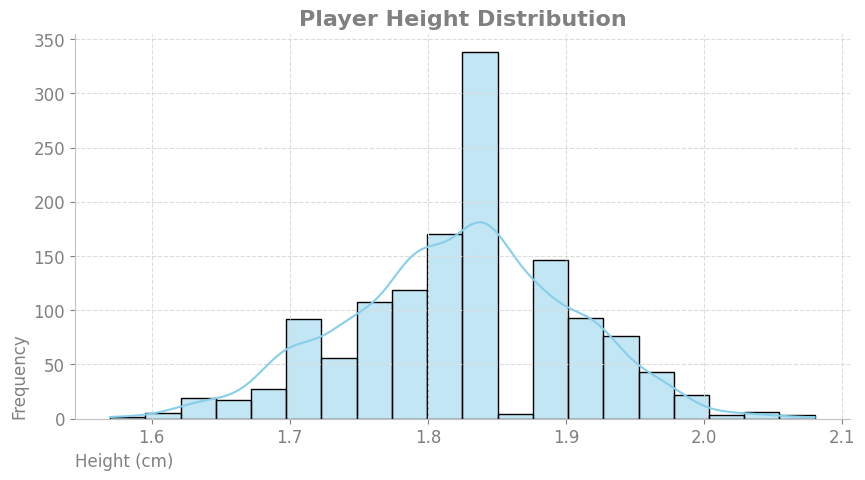

In [4]:
heights = unique_heights_df['height']

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(heights,
             kde=True,
             bins = 20,
             color="skyblue")

ax.spines[["right", "top"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("#c2c2c2")

ax.set_title("Player Height Distribution",
             weight="bold",
             color="grey",
             fontsize=16)

ax.set_xlabel("Height (cm)", loc="left", fontsize=12, color="grey")
ax.set_ylabel("Frequency", loc="bottom", fontsize=12, color="grey")

ax.tick_params(axis="x", colors="grey", labelsize="large")
ax.tick_params(axis="y", colors="grey", labelsize="large")

ax.grid(linestyle="dashed", color="gainsboro")

plt.savefig("../outputs/figures/PlayersAvgHeight.png", dpi=300)
plt.show()

# **Conclusion**

After scanning over `316,000` parquet files, a large portion — approximately `84%` — had to be skipped due to structural issues or missing essential columns. Still, the remaining `27,861` valid rows provided sufficient data to extract `1,349` unique players with valid height information.

The calculated average height of `1.82 meters` aligns well with expectations for professional tennis players, confirming that despite the high skip rate, the cleaned dataset retained meaningful and reliable entries.

This process demonstrated the effectiveness of parallelized data loading using `ThreadPoolExecutor`, which significantly reduced read times across hundreds of thousands of files. 

The integration of `tqdm` provided real-time progress tracking, allowing visibility into file processing status without interrupting the workflow. 

By applying strict column filtering, only the necessary information `(player_id and height)` was loaded, reducing memory overhead. 

Additionally, through row-level cleaning and deduplication by player ID, accurate player-level statistics were extracted. Despite a high number of unreadable files, the final dataset preserved enough integrity to compute a reliable average height across a large set of unique players.